In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("dataset/ndvi-lluvia-tmin-tmax.csv")
df.drop(columns=["departamento", "municipio", "viq", "date", "tdelta"], inplace=True)
df.ADM2_PCODE = df.ADM2_PCODE.map(lambda x: int(x[2:]))

df = df.sort_values(["ADM2_PCODE", "anio", "mes"])
df["mes_anterior"] = df.vim.shift(1)
df["anio_anterior"] = df.vim.shift(12)
df = df.fillna(df.vim.mean())
df.head()


,anio,mes,ADM2_PCODE,n_pixels,vim,lon,lat,precipitacion,tmin,tmax,mes_anterior,anio_anterior
0,2002,7,100,1.0,0.686067,-90.548878,14.435029,169.31514,16.139826,25.118555,0.714961,0.714961
315,2002,8,100,1.0,0.708233,-90.548878,14.435029,142.08778,15.987413,26.113989,0.686067,0.714961
625,2002,9,100,1.0,0.734633,-90.548878,14.435029,339.54276,16.080233,23.929758,0.708233,0.714961
940,2002,10,100,1.0,0.723900,-90.548878,14.435029,210.85938,15.551269,25.299889,0.734633,0.714961
1255,2002,11,100,1.0,0.664500,-90.548878,14.435029,120.49731,13.947153,24.349771,0.723900,0.714961


In [3]:
df.describe()

,anio,mes,ADM2_PCODE,n_pixels,vim,lon,lat,precipitacion,tmin,tmax,mes_anterior,anio_anterior
count,81264.000000,81264.000000,81264.000000,81264.000000,81264.000000,81264.000000,81264.000000,81264.000000,81264.000000,81264.000000,81264.000000,81264.000000
mean,2012.744955,6.569723,1137.567262,11.378470,0.714961,-90.828353,14.929289,156.292752,14.651970,27.186788,0.714962,0.714968
std,6.209488,3.451455,587.465072,24.642132,0.111696,0.798608,0.597030,159.071855,5.880862,5.183560,0.111696,0.111687
min,2002.000000,1.000000,100.000000,1.000000,0.249600,-92.119786,13.910458,0.000000,-5.192460,9.929691,0.249600,0.249600
25%,2007.000000,4.000000,614.000000,2.000000,0.649400,-91.533353,14.549615,22.345301,10.055494,23.044897,0.649400,0.649433
50%,2013.000000,7.000000,1211.000000,5.000000,0.753200,-90.898669,14.823235,112.010750,15.476129,27.651499,0.753200,0.753200
75%,2018.000000,10.000000,1601.000000,10.000000,0.800633,-90.203816,15.197355,243.600020,19.569326,31.635446,0.800633,0.800633
max,2023.000000,12.000000,2217.000000,275.000000,0.891533,-88.490611,17.489473,1306.445800,34.548480,40.322803,0.891533,0.891533


In [4]:
df_train = df[df.anio < 2020].copy().sort_values(["ADM2_PCODE", "anio", "mes"]).drop(columns="anio")
df_test = df[df.anio >= 2020].copy().sort_values(["ADM2_PCODE", "anio", "mes"]).drop(columns="anio")

ytest = df_test.vim.values
Xtest = df_test.drop(columns="vim")
ytrain = df_train.vim.values
Xtrain = df_train.drop(columns="vim")

Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((66144, 10), (66144,), (15120, 10), (15120,))

In [5]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
Xtrain_sc = pd.DataFrame(sc.fit_transform(Xtrain), columns=Xtrain.columns)
Xtest_sc = pd.DataFrame(sc.transform(Xtest), columns=Xtest.columns)

In [6]:
df_train_sc = Xtrain_sc.copy()
df_train_sc["vim"] = ytrain

df_test_sc = Xtest_sc.copy()
df_test_sc["vim"] = ytest

df_train_sc.head()

,mes,ADM2_PCODE,n_pixels,lon,lat,precipitacion,tmin,tmax,mes_anterior,anio_anterior,vim
0,0.545455,0.0,0.0,0.432856,0.146569,0.145635,0.527881,0.518564,0.724937,0.724937,0.686067
1,0.636364,0.0,0.0,0.432856,0.146569,0.122215,0.523973,0.552549,0.679925,0.724937,0.708233
2,0.727273,0.0,0.0,0.432856,0.146569,0.292054,0.526353,0.477977,0.714456,0.724937,0.734633
3,0.818182,0.0,0.0,0.432856,0.146569,0.181368,0.512787,0.524755,0.755582,0.724937,0.723900
4,0.909091,0.0,0.0,0.432856,0.146569,0.103645,0.471647,0.492317,0.738862,0.724937,0.664500


In [68]:
def create_dataset(df, lookback):
    X_ans = []
    y_ans = []

    for c in df.ADM2_PCODE.unique():
        X = df[df.ADM2_PCODE == c].drop(columns=["vim"]).values
        y = df[df.ADM2_PCODE == c].vim.values
        for k in range(len(X) - lookback):
            feat = X[k : k + lookback]
            target = y[k : k + lookback]
            X_ans.append(feat)
            y_ans.append(target)

    return np.array(X_ans), np.array(y_ans).reshape(-1, lookback, 1)

In [69]:
LOOKBACK = 12

In [70]:
X_train, y_train = create_dataset(df_train_sc, LOOKBACK)
X_train.shape, y_train.shape

((62364, 12, 10), (62364, 12, 1))

In [71]:
X_test, y_test = create_dataset(df_test_sc, LOOKBACK)
X_test.shape, y_test.shape

((11340, 12, 10), (11340, 12, 1))

# LSTM

In [53]:
import torch 
import torch.nn as nn
from torch.optim import Adam 
from torch.utils.data import TensorDataset, DataLoader

In [54]:
torch.manual_seed(1)

In [72]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float)

In [73]:
class VimModel(nn.Module):
    def __init__(self, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=10, hidden_size=hidden_size, batch_first=True, num_layers=num_layers)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        # x = x[:, -1, :]
        x = self.relu(x)
        return self.linear(x)

In [74]:
model = VimModel(hidden_size=32, num_layers=2)
model(X_test_tensor).shape

torch.Size([11340, 12, 1])

In [75]:
model = VimModel(hidden_size=32, num_layers=2)
opt = Adam(model.parameters(), lr=1e-3)
loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), shuffle=True, batch_size=16)
mse = nn.L1Loss()


epochs = 50

train_loss = []
test_loss = []

patience = 5
counter = 0
best = 9999
best_dict = {}

for e in range(epochs):
    model.train()
    temp = []
    cnt = 0
    for X_batch, y_batch in loader:
        model.train()
        y_pred = model(X_batch)
        loss = mse(y_batch, y_pred)
        opt.zero_grad()
        loss.backward()
        opt.step()
        temp.append(torch.mean(torch.abs(y_pred - y_batch) / y_batch).item())
        cnt += 1

        if cnt % 1_000 == 0:
            train_loss.append(np.mean(temp))
            temp = []
            model.eval()
            y_pred = model(X_test_tensor)
            test_loss.append(torch.mean(torch.abs(y_pred - y_test_tensor) / y_test_tensor).item())

            if test_loss[-1] < best:
                counter = 0
                best = test_loss[-1]
                best_dict = model.state_dict()
            else:
                counter += 1

            print(f"Epoch {e:2d}, iter {cnt:4d}, MAPE Entrenamiento {train_loss[-1]:.4f}, MAPE Evaluación {test_loss[-1]:.4f}")

    if counter >= patience: break

model.load_state_dict(best_dict)
torch.save(model.state_dict(), "best_lstm")

Epoch  0, iter 1000, MAPE Entrenamiento 0.0932, MAPE Evaluación 0.0205
Epoch  0, iter 2000, MAPE Entrenamiento 0.0214, MAPE Evaluación 0.0174
Epoch  0, iter 3000, MAPE Entrenamiento 0.0170, MAPE Evaluación 0.0126
Epoch  1, iter 1000, MAPE Entrenamiento 0.0152, MAPE Evaluación 0.0129
Epoch  1, iter 2000, MAPE Entrenamiento 0.0148, MAPE Evaluación 0.0119
Epoch  1, iter 3000, MAPE Entrenamiento 0.0146, MAPE Evaluación 0.0121
Epoch  2, iter 1000, MAPE Entrenamiento 0.0141, MAPE Evaluación 0.0123
Epoch  2, iter 2000, MAPE Entrenamiento 0.0136, MAPE Evaluación 0.0109
Epoch  2, iter 3000, MAPE Entrenamiento 0.0136, MAPE Evaluación 0.0113
Epoch  3, iter 1000, MAPE Entrenamiento 0.0131, MAPE Evaluación 0.0123
Epoch  3, iter 2000, MAPE Entrenamiento 0.0131, MAPE Evaluación 0.0110
Epoch  3, iter 3000, MAPE Entrenamiento 0.0130, MAPE Evaluación 0.0111
Epoch  4, iter 1000, MAPE Entrenamiento 0.0126, MAPE Evaluación 0.0108
Epoch  4, iter 2000, MAPE Entrenamiento 0.0124, MAPE Evaluación 0.0109
Epoch 

In [12]:
import matplotlib.pyplot as plt 

Text(0, 0.5, 'MAPE')

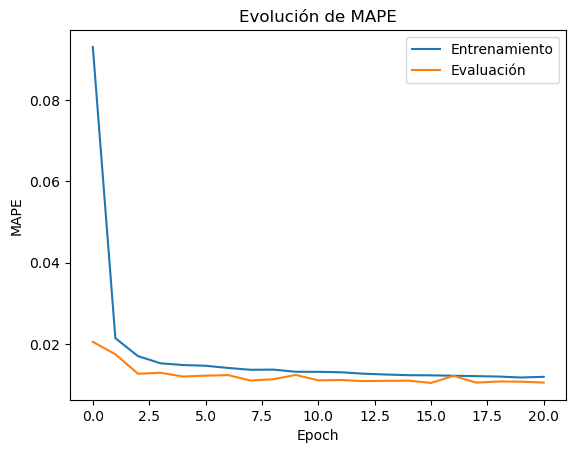

In [76]:


plt.plot(train_loss, label="Entrenamiento")
plt.plot(test_loss, label="Evaluación")
plt.legend()
plt.title("Evolución de MAPE")
plt.xlabel("Epoch")
plt.ylabel("MAPE")

In [77]:

model.load_state_dict(torch.load("best_lstm"))

<All keys matched successfully>

In [7]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [79]:
ypred_train = model(X_train_tensor).detach().numpy()[:, -1, :]
ytrue_train = y_train[:, -1, :]

mape, r2 = mean_absolute_percentage_error(ytrue_train, ypred_train), r2_score(ytrue_train, ypred_train)

print(f"MAPE Entrenamiento: {mape*100:.2f} %, R2 Entrenamiento: {r2*100:.2f} %")

MAPE Entrenamiento: 0.94 %, R2 Entrenamiento: 99.35 %


In [80]:
ypred_test = model(X_test_tensor).detach().numpy()[:, -1, :]
ytrue_test = y_test[:, -1, :]

mape, r2 = mean_absolute_percentage_error(ytrue_test, ypred_test), r2_score(ytrue_test, ypred_test)
print(f"MAPE Evaluación: {mape*100:.2f} %, R2 Evaluación: {r2*100:.2f} %")

MAPE Evaluación: 0.89 %, R2 Evaluación: 99.34 %


Text(0.5, 0.98, 'Predicción perfecta LSTM')

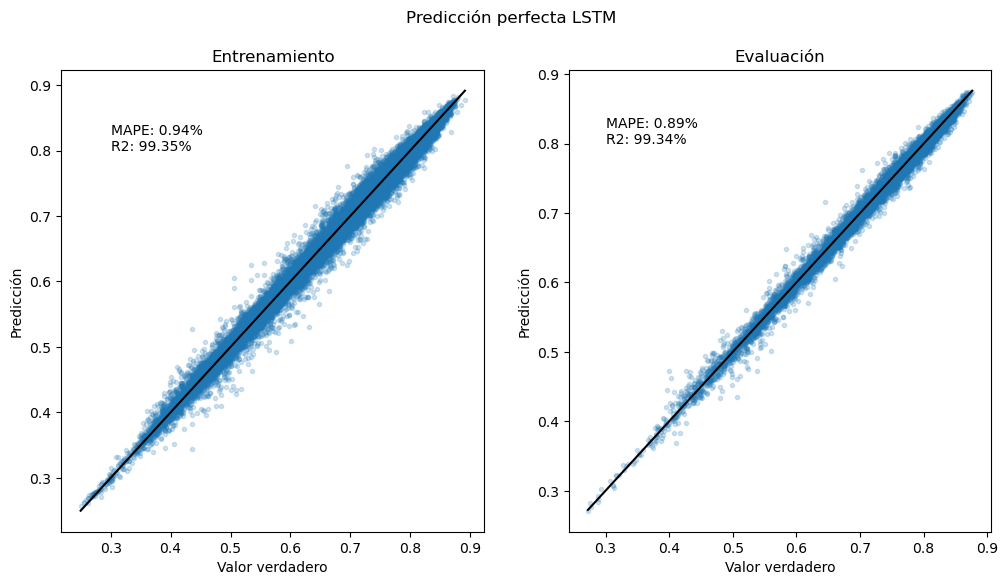

In [83]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(ytrue_train, ypred_train, ".", alpha=0.2)
plt.plot([ytrue_train.min(), ytrue_train.max()], [ytrue_train.min(), ytrue_train.max()], "k")
plt.title("Entrenamiento")
plt.xlabel("Valor verdadero")
plt.ylabel("Predicción")
plt.text(0.3, 0.8, "MAPE: 0.94%\nR2: 99.35%")

plt.subplot(122)
plt.plot(ytrue_test, ypred_test, ".", alpha=0.2)
plt.plot([ytrue_test.min(), ytrue_test.max()], [ytrue_test.min(), ytrue_test.max()], "k")
plt.title("Evaluación")
plt.xlabel("Valor verdadero")
plt.ylabel("Predicción")
plt.text(0.3, 0.8, "MAPE: 0.89%\nR2: 99.34%")
 
plt.suptitle("Predicción perfecta LSTM")

In [93]:
results_lstm = pd.DataFrame(X_test[:, -1, :], columns=[c for c in Xtest.columns])
results_lstm.ADM2_PCODE = results_lstm.ADM2_PCODE * 175 + 100
results_lstm.ADM2_PCODE = results_lstm.ADM2_PCODE.astype(np.int8)
results_lstm["vim"] = ytrue_test
results_lstm["pred"] = ypred_test
results_lstm.head()

,mes,ADM2_PCODE,n_pixels,lon,lat,precipitacion,tmin,tmax,mes_anterior,anio_anterior,vim,pred
0,1.000000,100,0.0,0.432856,0.146569,0.015470,0.473946,0.456166,0.654897,0.544034,0.618100,0.611803
1,0.000000,100,0.0,0.432856,0.146569,0.012392,0.476027,0.477134,0.574047,0.447658,0.541267,0.551044
2,0.090909,100,0.0,0.432856,0.146569,0.007206,0.467863,0.499799,0.454357,0.348738,0.470500,0.477318
3,0.181818,100,0.0,0.432856,0.146569,0.004207,0.506208,0.539862,0.344117,0.291567,0.422933,0.432650
4,0.272727,100,0.0,0.432856,0.146569,0.059531,0.563757,0.535511,0.270018,0.300395,0.424200,0.429978


In [95]:
results_lstm.to_csv("results_lstm.csv", index=False)

# Regresión Lineal

In [8]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(Xtrain_sc, ytrain)

LinearRegression()

In [14]:
ypred_train = lr.predict(Xtrain_sc)
mean_absolute_percentage_error(ytrain, ypred_train), r2_score(ytrain, ypred_train)

(0.034298425919324936, 0.921362791844348)

In [15]:


ypred_test = lr.predict(Xtest_sc)
mean_absolute_percentage_error(ytest, ypred_test), r2_score(ytest, ypred_test)

(0.02897197374583821, 0.9380136302037652)

Text(0.5, 0.98, 'Predicción perfecta Regresión Lineal')

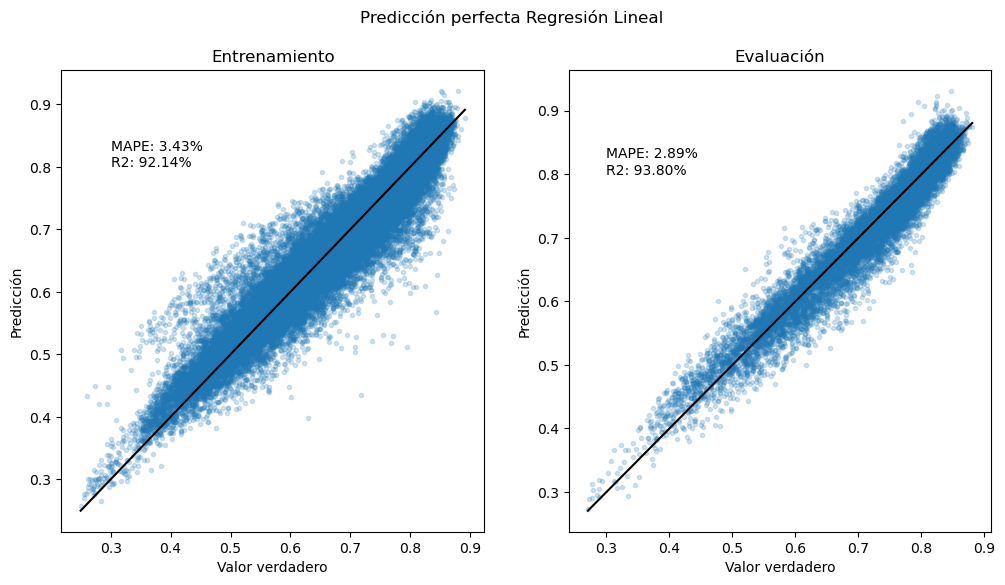

In [16]:


plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(ytrain, ypred_train, ".", alpha=0.2)
plt.plot([ytrain.min(), ytrain.max()], [ytrain.min(), ytrain.max()], "k")
plt.title("Entrenamiento")
plt.xlabel("Valor verdadero")
plt.ylabel("Predicción")
plt.text(0.3, 0.8, "MAPE: 3.43%\nR2: 92.14%")

plt.subplot(122)
plt.plot(ytest, ypred_test, ".", alpha=0.2)
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], "k")
plt.title("Evaluación")
plt.xlabel("Valor verdadero")
plt.ylabel("Predicción")
plt.text(0.3, 0.8, "MAPE: 2.89%\nR2: 93.80%")
 
plt.suptitle("Predicción perfecta Regresión Lineal")

In [20]:
results_lr = Xtest.copy()
results_lr["vim"] = ytest
results_lr["pred"] = ypred_test
results_lr.head()

,mes,ADM2_PCODE,n_pixels,lon,lat,precipitacion,tmin,tmax,mes_anterior,anio_anterior,vim,pred
66144,1,100,1.0,-90.548878,14.435029,11.957325,14.573679,24.749140,0.598833,0.508467,0.536967,0.569362
66459,2,100,1.0,-90.548878,14.435029,3.717238,15.223828,26.233910,0.536967,0.455900,0.473467,0.513859
66774,3,100,1.0,-90.548878,14.435029,8.406713,15.688089,26.767462,0.473467,0.428833,0.436767,0.469988
67089,4,100,1.0,-90.548878,14.435029,57.955020,17.494720,27.414968,0.436767,0.451967,0.442433,0.466747
67404,5,100,1.0,-90.548878,14.435029,286.092300,17.966017,25.950335,0.442433,0.541867,0.512667,0.527406


In [21]:
results_lr.to_csv("results_lr.csv")

In [22]:
import seaborn as sns

Text(0, 0.5, 'Variable')

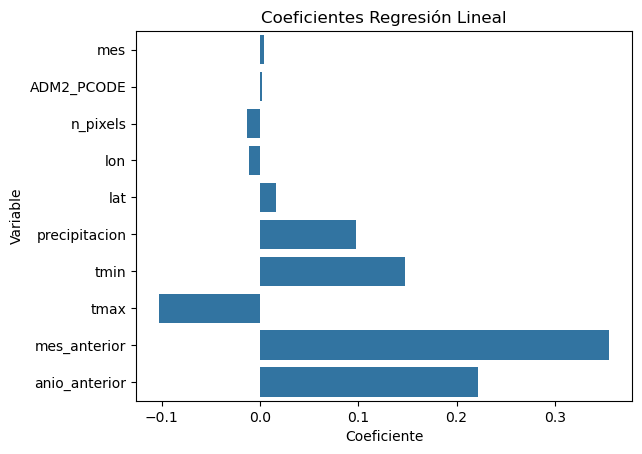

In [24]:

imp = pd.DataFrame({"var": Xtrain.columns, "imp": lr.coef_})
sns.barplot(imp, x="imp", y="var")
plt.title("Coeficientes Regresión Lineal")
plt.xlabel("Coeficiente")
plt.ylabel("Variable")

# LGBMRegressor

In [25]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

In [26]:
lg = LGBMRegressor(random_state = 1)
params = {
    "num_leaves": [20, 31, 50]
}
gs = GridSearchCV(lg, params, cv=5)
gs.fit(Xtrain_sc, ytrain)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2090
[LightGBM] [Info] Number of data points in the train set: 52915, number of used features: 10
[LightGBM] [Info] Start training from score 0.718671
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2093
[LightGBM] [Info] Number of data points in the train set: 52915, number of used features: 10
[LightGBM] [Info] Start training from score 0.716097
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=1),
             param_grid={'num_leaves': [20, 31, 50]})

In [37]:
best_params = gs.best_params_
print(best_params)
lg = LGBMRegressor(**best_params, random_state=1)
lg.fit(Xtrain_sc, ytrain)

{'num_leaves': 50}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 66144, number of used features: 10
[LightGBM] [Info] Start training from score 0.712593


LGBMRegressor(num_leaves=50, random_state=1)

In [38]:
ypred_train = lg.predict(Xtrain_sc)
mean_absolute_percentage_error(ytrain, ypred_train), r2_score(ytrain, ypred_train)

(0.01417432033638468, 0.9868018344048908)

In [39]:
ypred_test = lg.predict(Xtest_sc)
mean_absolute_percentage_error(ytest, ypred_test), r2_score(ytest, ypred_test)

(0.013775358202848535, 0.9854710163480508)

Text(0.5, 0.98, 'Predicción Perfecta LGBMRegressor')

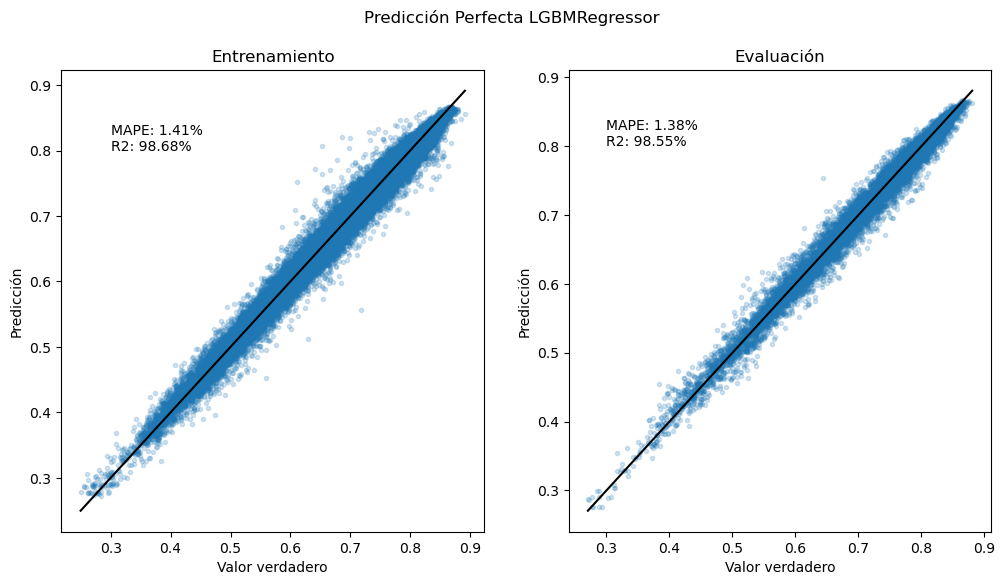

In [40]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(ytrain, ypred_train, ".", alpha=0.2)
plt.plot([ytrain.min(), ytrain.max()], [ytrain.min(), ytrain.max()], "k")
plt.title("Entrenamiento")
plt.xlabel("Valor verdadero")
plt.ylabel("Predicción")
plt.text(0.3, 0.8, "MAPE: 1.41%\nR2: 98.68%")

plt.subplot(122)
plt.plot(ytest, ypred_test, ".", alpha=0.2)
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], "k")
plt.title("Evaluación")
plt.xlabel("Valor verdadero")
plt.ylabel("Predicción")
plt.text(0.3, 0.8, "MAPE: 1.38%\nR2: 98.55%")
 
plt.suptitle("Predicción Perfecta LGBMRegressor")

Text(0, 0.5, 'Variable')

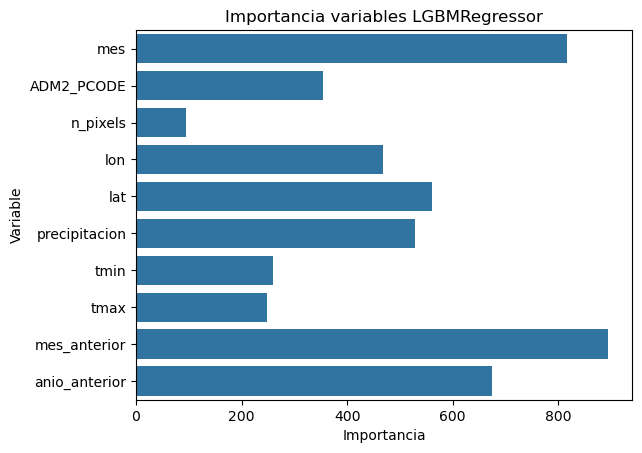

In [41]:
imp = pd.DataFrame({"var": Xtrain.columns, "imp": lg.feature_importances_})
sns.barplot(imp, x="imp", y="var")
plt.title("Importancia variables LGBMRegressor")
plt.xlabel("Importancia")
plt.ylabel("Variable")

In [42]:
results_lgbm = Xtest.copy()
results_lgbm["vim"] = ytest
results_lgbm["pred"] = ypred_test
results_lgbm.head()

,mes,ADM2_PCODE,n_pixels,lon,lat,precipitacion,tmin,tmax,mes_anterior,anio_anterior,vim,pred
66144,1,100,1.0,-90.548878,14.435029,11.957325,14.573679,24.749140,0.598833,0.508467,0.536967,0.523775
66459,2,100,1.0,-90.548878,14.435029,3.717238,15.223828,26.233910,0.536967,0.455900,0.473467,0.472857
66774,3,100,1.0,-90.548878,14.435029,8.406713,15.688089,26.767462,0.473467,0.428833,0.436767,0.437817
67089,4,100,1.0,-90.548878,14.435029,57.955020,17.494720,27.414968,0.436767,0.451967,0.442433,0.464519
67404,5,100,1.0,-90.548878,14.435029,286.092300,17.966017,25.950335,0.442433,0.541867,0.512667,0.545532


In [43]:
results_lgbm.to_csv("results_lgbm.csv")